# Credit Card Fraud Detection Analysis

In today’s digital world, trillions of credit card transactions occur daily, making fraud detection increasingly challenging. This project utilized a dataset sourced from an unnamed institute, focusing on identifying fraudulent transactions based on several key features:

- distance_from_home: the distance from home where the transaction occurred
- distance_from_last_transaction: the distance from the previous transaction
- ratio_to_median_purchase_price: the ratio of the transaction price to the median purchase price
- repeat_retailer: whether the transaction occurred at the same retailer
- used_chip: whether the credit card's chip was used
- used_pin_number: whether the transaction involved a PIN number
- online_order: whether the transaction was an online order
- fraud: a flag indicating if the transaction was fraudulent

This dataset provides valuable insights into detecting both Card-Present and Card-not Present fraud in an evolving digital payments landscape.

### Summary:
By applying Stratified K-Fold cross-validation and utilizing a Random Forest Classifier, we achieved an accuracy rate of over 95% in detecting fraudulent transactions. Key features, such as distance_from_home, distance_from_last_transaction, and the ratio_to_median_purchase_price (making large purchases), were identified as significant predictors of fraud. This model provided stakeholders with reliable insights into potential fraud patterns, enhancing the efficiency and accuracy of fraud detection systems.

# Data Cleaning

**Imports**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

**Read in Data**

In [2]:
data = pd.read_csv('./data/card_transdata.csv')
data.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


### Findings 

* The units for distances in the dataset are not specified, but for analysis purposes, we assumed they are either in miles or kilometers.
* 75% of transactions have no fraud.
* On average, 8.74% of transcations are fraudulent
* The chip reader was used in 35.04% of transactions
* PIN was used in 10.06% of transactions
* Some of these are binary columns because the min is 0 and the max is 1 
* 65.06% of the orders were online
* 88.15% of these order were from repeat retailers

**Check for duplicates**

In [3]:
data.drop_duplicates(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   distance_from_home              1000000 non-null  float64
 1   distance_from_last_transaction  1000000 non-null  float64
 2   ratio_to_median_purchase_price  1000000 non-null  float64
 3   repeat_retailer                 1000000 non-null  float64
 4   used_chip                       1000000 non-null  float64
 5   used_pin_number                 1000000 non-null  float64
 6   online_order                    1000000 non-null  float64
 7   fraud                           1000000 non-null  float64
dtypes: float64(8)
memory usage: 68.7 MB


### Findings

* No null values
* All clumns at dtype: float
* 1,000,000 observations in the data set
* No dataset changes needed

# Data Exploration

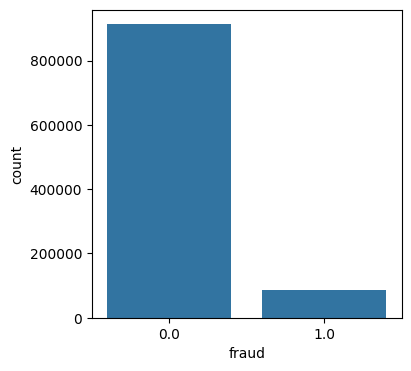

In [4]:
plt.figure(figsize=(4,4))

ax = sns.countplot(x=data['fraud'], order=data['fraud'].value_counts().index) 

There is a higher number of unfradulent transactions

**Check for outliers in continuous variables**

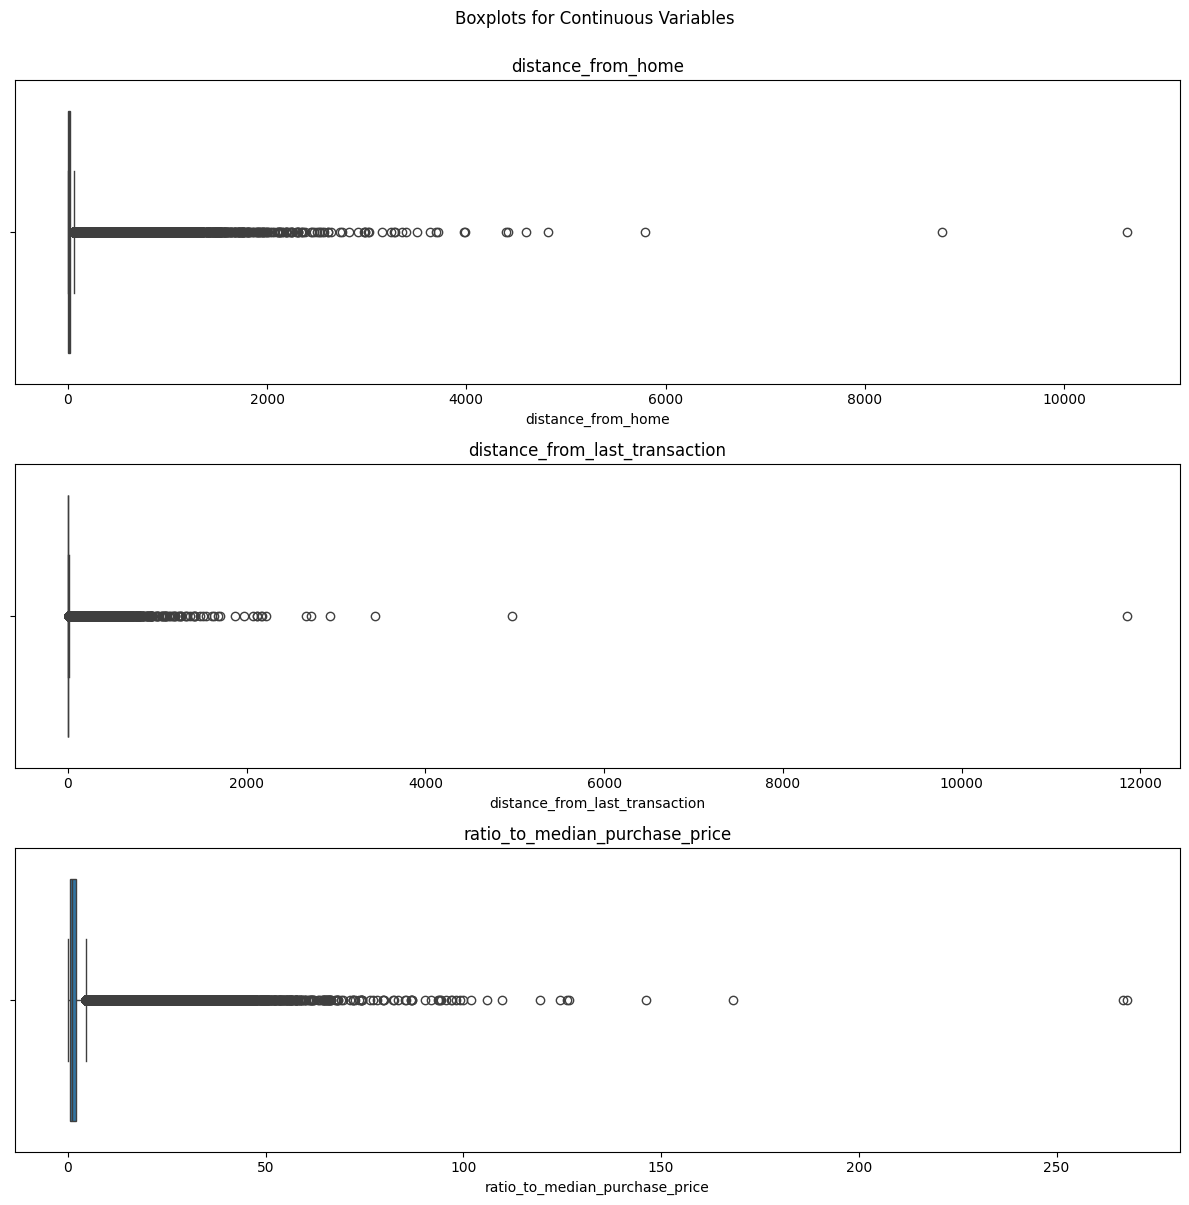

In [5]:
# Make boxplots to find disparity of continuous variables

def create_boxplot(data, rows, columns):
    fig, axes = plt.subplots(nrows=rows, figsize=(12, 12))
    fig.suptitle('Boxplots for Continuous Variables', y=1) #y=1 puts title at the top
    for i, col in enumerate(columns): #enumerate allows you to return 2 things in one line (index and object in a list)
        sns.boxplot(data=data[col], orient='h', ax=axes[i])
        axes[i].set_title(col)
    fig.tight_layout()

create_boxplot(data, 3, ['distance_from_home', 'distance_from_last_transaction', 'ratio_to_median_purchase_price'])

**Remove Outliers**

In [6]:
from collections import Counter

def IQR_method(data, cols):
    outliers = []
    for col in cols:
        Q1 = np.percentile(data[col], 25)
        Q3 = np.percentile(data[col], 75)
        IQR = Q3 - Q1
        outlier_range = IQR * 1.5

        outliers.extend(data[(data[col] < Q1 - outlier_range) | (data[col] > Q3 + outlier_range)].index)

    outliers = Counter(outliers)
    return [row for row, count in outliers.items() if count > 1]

data_cleaned = data.drop(IQR_method(data, ['distance_from_home', 'distance_from_last_transaction', 'ratio_to_median_purchase_price']), axis=0).reset_index(drop=True)

**Plot with cleaned / removed outliers**

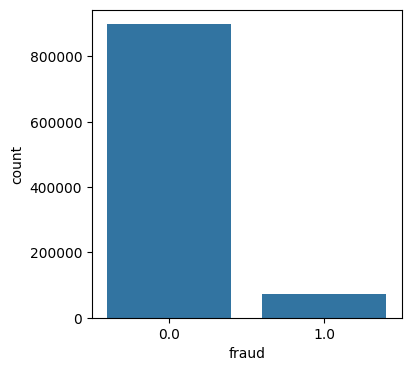

In [7]:
plt.figure(figsize=(4,4))

ax = sns.countplot(x=data_cleaned['fraud'], order=data_cleaned['fraud'].value_counts().index) 

## Data Modeling - Stratified Sampling

This data set is so small that we wanna make sure we get good representation of both groups.

In [8]:
X = data_cleaned.drop('fraud', axis=1)
y = data_cleaned['fraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=8) #test_size can be 0.2 - 0.3

In [9]:
# Standard Scaling - DATA CLEANING DONE !

# Scale X_train
numeric_cols = ['distance_from_home', 'distance_from_last_transaction', 'ratio_to_median_purchase_price']
scaler = StandardScaler()
features = scaler.fit_transform(X_train[numeric_cols])
X_train[numeric_cols] = features # scaling these so no crazy huge numbers

# Scale X_test
scaler = StandardScaler()
features = scaler.fit_transform(X_test[numeric_cols])
X_test[numeric_cols] = features

### Cross Validation - Kfold

In [11]:
# It's a good way to estimate how good the model will be on the data set
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier

kf = StratifiedKFold(n_splits=5, shuffle=False)
clf = RandomForestClassifier(n_estimators=100, random_state=8, n_jobs=-1)

score = cross_val_score(clf, X_train, y_train, cv=kf, scoring='recall')
score.mean()

0.9998608665403796

With a score of 0.9998608665403796, our model will be highly accurate

### Evaluate Model using Confusing Matrix

In [ ]:
# Evaluating model and seeing how good it is

from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, accuracy_score

clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

cm

# TP   FP
# FN   TN

array([[179201,    426],
       [   448,  13927]], dtype=int64)

This model shows that there are more True Positives and True Negatives than there are the former. In the case for detecting fraudulent transactions, this is highy successful.

### Model Scoring Metrics

In [ ]:
pd.DataFrame([(recall, precision, f1, accuracy)], columns=['Recall', 'Precision', 'F1', 'Accuracy'])

,Recall,Precision,F1,Accuracy
0,0.968835,0.97032,0.969577,0.995495


### Feature importances. How important every single feature (column) is

<Axes: ylabel='None'>

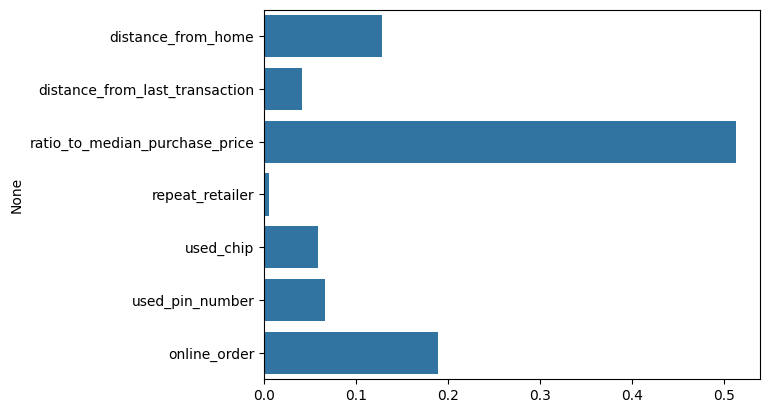

In [ ]:
sns.barplot(x=clf.feature_importances_, y=X.columns)

# FEATURE importances are just a thing with Random Forest where there is a bunch of decision trees and obtains the weights from that

# Summary

Despite high recall, the overall performance could benefit from further refinement, like tuning hyperparameters or exploring alternative models to address the slight trade-off in accuracy.